In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torchvision.transforms.functional as TF
import pathlib
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import multiprocessing
import os
import random
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [2]:
data_dir = "./data"
train_dir = pathlib.Path(data_dir) / "train"
test_dir = pathlib.Path(data_dir) / "test"

In [3]:
# Custom Dataset Class
class SkinCancerDataset(Dataset):
    def __init__(self, data_dir, transform=None, subset=None, validation_split=0.0, seed=42):
        self.data_dir = pathlib.Path(data_dir)
        self.transform = transform
        self.subset = subset
        self.validation_split = validation_split

        # Get all image paths and labels
        self.benign_paths = list((self.data_dir / "benign").glob("*"))
        self.malignant_paths = list((self.data_dir / "malignant").glob("*"))

        # Set random seed for reproducibility
        random.seed(seed)

        # Split data if needed
        if subset and validation_split > 0:
            all_benign = self.benign_paths.copy()
            all_malignant = self.malignant_paths.copy()

            # Shuffle
            random.shuffle(all_benign)
            random.shuffle(all_malignant)

            # Split
            benign_split = int(len(all_benign) * (1 - validation_split))
            malignant_split = int(len(all_malignant) * (1 - validation_split))

            if subset == 'training':
                self.benign_paths = all_benign[:benign_split]
                self.malignant_paths = all_malignant[:malignant_split]
            elif subset == 'validation':
                self.benign_paths = all_benign[benign_split:]
                self.malignant_paths = all_malignant[malignant_split:]

        # Combine paths and create labels
        self.image_paths = self.benign_paths + self.malignant_paths
        self.labels = [0] * len(self.benign_paths) + [1] * len(self.malignant_paths)

        # Shuffle the dataset with the same seed
        combined = list(zip(self.image_paths, self.labels))
        random.seed(seed)
        random.shuffle(combined)
        self.image_paths, self.labels = zip(*combined)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = torch.tensor(self.labels[idx]).float().squeeze()

        # Load image
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Data Augmentation and Transforms
train_transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((380, 380)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
# Create datasets
train_dataset = SkinCancerDataset(
    train_dir,
    transform=train_transform,
    subset='training',
    validation_split=0.1,
    seed=42
)

val_dataset = SkinCancerDataset(
    train_dir,
    transform=val_test_transform,
    subset='validation',
    validation_split=0.1,
    seed=42
)

test_dataset = SkinCancerDataset(
    test_dir,
    transform=val_test_transform
)

In [6]:
# Print dataset sizes
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 8644
Validation dataset size: 961
Test dataset size: 1000


In [7]:
# 5. Create DataLoaders
num_workers = min(24, multiprocessing.cpu_count())
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=num_workers)
num_workers

24

In [8]:
# 6. Handle Class Imbalance
benign_count = len(list((train_dir / "benign").glob("*")))
malignant_count = len(list((train_dir / "malignant").glob("*")))
total = benign_count + malignant_count

# Calculate weights for weighted loss
class_weights = {
    0: total / (2 * benign_count),
    1: total / (2 * malignant_count)
}
print(f"Class weights: {class_weights}")

# PyTorch class weights format
weight_tensor = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32)

Class weights: {0: 0.9605, 1: 1.0428881650380022}


In [9]:
# 7. Create EfficientNet Model with PyTorch
class SkinCancerModel(nn.Module):
    def __init__(self):
        super(SkinCancerModel, self).__init__()

        # Load pre-trained EfficientNet-B4
        self.efficientnet = models.efficientnet_b4(weights='DEFAULT')

        # Unfreeze the last few layers for fine-tuning
        for name, param in self.efficientnet.named_parameters():
            if 'features.7' in name or 'features.8' in name:
                param.requires_grad = True
            else:
                param.requires_grad = False

        # Modify the classifier
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.efficientnet(x)
        return x

In [10]:
# 8. Initialize model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model = SkinCancerModel().to(device)

# Use a lower learning rate for fine-tuning
optimizer = optim.Adam([
    {'params': [p for n, p in model.named_parameters() if 'classifier' in n], 'lr': 1e-4},
    {'params': [p for n, p in model.named_parameters() if 'classifier' not in n and p.requires_grad], 'lr': 1e-5}
])

pos_weight = torch.tensor([class_weights[1] / class_weights[0]]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

Using device: cuda


In [11]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    progress = tqdm(dataloader, desc="Training", leave=False)
    for inputs, labels in progress:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze(dim=1)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        progress.set_postfix(loss=loss.item(), acc=(correct / (total + 1e-6)))

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total

    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        progress = tqdm(dataloader, desc="Validating", leave=False)
        for inputs, labels in progress:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs).squeeze(dim=1)
            loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store for metrics
            all_outputs.append(outputs.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

            progress.set_postfix(loss=loss.item(), acc=(correct / (total + 1e-6)))

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct / total

    # Calculate AUC, precision, recall using sklearn
    all_outputs = np.concatenate(all_outputs)
    all_labels = np.concatenate(all_labels)

    # Convert logits to probabilities for AUC calculation
    all_probs = 1 / (1 + np.exp(-all_outputs))
    all_preds = (all_probs > 0.5).astype(np.float32)

    # Calculate metrics
    try:
        auc = roc_auc_score(all_labels, all_probs)
        precision = precision_score(all_labels, all_preds, zero_division=0)
        recall = recall_score(all_labels, all_preds, zero_division=0)
    except Exception as e:
        print(f"Warning: Error calculating metrics: {e}")
        auc = 0.5  # Default AUC (random classifier)
        precision = 0.0
        recall = 0.0

    return epoch_loss, epoch_acc, auc, precision, recall

In [12]:
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

In [13]:
# 10. Training Loop
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=50, patience=10):
    best_val_auc = 0.5  # Start with baseline AUC (random classifier)
    patience_counter = 0
    best_model_weights = None

    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_precision': [], 'val_recall': []
    }

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc, val_auc, val_precision, val_recall = validate(model, val_loader, criterion, device)

        # Update learning rate if scheduler is provided
        if scheduler is not None:
            scheduler.step(val_auc)

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_auc'].append(val_auc)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}")
        print(f"Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}")

        # Check if this is the best model
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            patience_counter = 0
            best_model_weights = model.state_dict().copy()
            torch.save(model.state_dict(), 'best_model_b4.pth')
            print("Saved best model!")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs!")
            break

    # Load best model
    if best_model_weights:
        model.load_state_dict(best_model_weights)

    return model, history

In [14]:
# Plot training history
def plot_history(history):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

    # Plot loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Val Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train Acc')
    ax2.plot(history['val_acc'], label='Val Acc')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Plot AUC, precision, recall
    ax3.plot(history['val_auc'], label='AUC')
    ax3.plot(history['val_precision'], label='Precision')
    ax3.plot(history['val_recall'], label='Recall')
    ax3.set_title('Validation Metrics')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Score')
    ax3.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

Epoch 1/30


Train Loss: 0.3982, Train Acc: 0.8274
Val Loss: 0.2405, Val Acc: 0.9043, Val AUC: 0.9685
Val Precision: 0.9163, Val Recall: 0.9024
Saved best model!
Epoch 2/30


Train Loss: 0.3383, Train Acc: 0.8619
Val Loss: 0.2306, Val Acc: 0.9084, Val AUC: 0.9707
Val Precision: 0.9052, Val Recall: 0.9111
Saved best model!
Epoch 3/30


Train Loss: 0.3326, Train Acc: 0.8649
Val Loss: 0.2212, Val Acc: 0.9095, Val AUC: 0.9736
Val Precision: 0.9238, Val Recall: 0.8937
Saved best model!
Epoch 4/30


Train Loss: 0.3233, Train Acc: 0.8668
Val Loss: 0.2050, Val Acc: 0.9272, Val AUC: 0.9776
Val Precision: 0.9275, Val Recall: 0.9154
Saved best model!
Epoch 5/30


Train Loss: 0.3214, Train Acc: 0.8719
Val Loss: 0.2086, Val Acc: 0.9199, Val AUC: 0.9766
Val Precision: 0.9345, Val Recall: 0.8980
Epoch 6/30


Train Loss: 0.3138, Train Acc: 0.8734
Val Loss: 0.2094, Val Acc: 0.9282, Val AUC: 0.9771
Val Precision: 0.8992, Val Recall: 0.9284
Epoch 7/30


Train Loss: 0.2972, Train Acc: 0.8775
Val Loss: 0.2022, Val Acc: 0.9157, Val AUC: 0.9785
Val Precision: 0.9493, Val Recall: 0.8937
Saved best model!
Epoch 8/30


Train Loss: 0.3049, Train Acc: 0.8761
Val Loss: 0.2002, Val Acc: 0.9199, Val AUC: 0.9784
Val Precision: 0.9386, Val Recall: 0.8959
Epoch 9/30


Train Loss: 0.2957, Train Acc: 0.8845
Val Loss: 0.1958, Val Acc: 0.9199, Val AUC: 0.9789
Val Precision: 0.9329, Val Recall: 0.9046
Saved best model!
Epoch 10/30


Train Loss: 0.2988, Train Acc: 0.8807
Val Loss: 0.1914, Val Acc: 0.9261, Val AUC: 0.9807
Val Precision: 0.9497, Val Recall: 0.9002
Saved best model!
Epoch 11/30


Train Loss: 0.2807, Train Acc: 0.8882
Val Loss: 0.1908, Val Acc: 0.9251, Val AUC: 0.9796
Val Precision: 0.9316, Val Recall: 0.9154
Epoch 12/30


Train Loss: 0.2905, Train Acc: 0.8859
Val Loss: 0.1918, Val Acc: 0.9313, Val AUC: 0.9804
Val Precision: 0.9320, Val Recall: 0.9219
Epoch 13/30


Train Loss: 0.2857, Train Acc: 0.8866
Val Loss: 0.1932, Val Acc: 0.9272, Val AUC: 0.9799
Val Precision: 0.9433, Val Recall: 0.9024
Epoch 14/30


Train Loss: 0.2731, Train Acc: 0.8924
Val Loss: 0.1913, Val Acc: 0.9292, Val AUC: 0.9799
Val Precision: 0.9365, Val Recall: 0.9284
Epoch 15/30


Train Loss: 0.2699, Train Acc: 0.8917
Val Loss: 0.1863, Val Acc: 0.9313, Val AUC: 0.9806
Val Precision: 0.9159, Val Recall: 0.9219
Epoch 16/30


Train Loss: 0.2657, Train Acc: 0.8958
Val Loss: 0.1818, Val Acc: 0.9303, Val AUC: 0.9810
Val Precision: 0.9397, Val Recall: 0.9132
Saved best model!
Epoch 17/30


Train Loss: 0.2697, Train Acc: 0.8960
Val Loss: 0.1802, Val Acc: 0.9303, Val AUC: 0.9812
Val Precision: 0.9397, Val Recall: 0.9132
Saved best model!
Epoch 18/30


Train Loss: 0.2707, Train Acc: 0.8900
Val Loss: 0.1824, Val Acc: 0.9272, Val AUC: 0.9818
Val Precision: 0.9540, Val Recall: 0.9002
Saved best model!
Epoch 19/30


Train Loss: 0.2718, Train Acc: 0.8941
Val Loss: 0.1771, Val Acc: 0.9292, Val AUC: 0.9822
Val Precision: 0.9443, Val Recall: 0.9197
Saved best model!
Epoch 20/30


Train Loss: 0.2538, Train Acc: 0.8998
Val Loss: 0.1845, Val Acc: 0.9230, Val AUC: 0.9808
Val Precision: 0.9455, Val Recall: 0.9024
Epoch 21/30


Train Loss: 0.2627, Train Acc: 0.8954
Val Loss: 0.1748, Val Acc: 0.9324, Val AUC: 0.9825
Val Precision: 0.9363, Val Recall: 0.9241
Saved best model!
Epoch 22/30


Train Loss: 0.2665, Train Acc: 0.8933
Val Loss: 0.1787, Val Acc: 0.9251, Val AUC: 0.9827
Val Precision: 0.9585, Val Recall: 0.9024
Saved best model!
Epoch 23/30


Train Loss: 0.2574, Train Acc: 0.8991
Val Loss: 0.1757, Val Acc: 0.9334, Val AUC: 0.9822
Val Precision: 0.9483, Val Recall: 0.9154
Epoch 24/30


Train Loss: 0.2571, Train Acc: 0.8966
Val Loss: 0.1747, Val Acc: 0.9251, Val AUC: 0.9828
Val Precision: 0.9543, Val Recall: 0.9067
Saved best model!
Epoch 25/30


Train Loss: 0.2535, Train Acc: 0.9037
Val Loss: 0.1830, Val Acc: 0.9230, Val AUC: 0.9817
Val Precision: 0.9559, Val Recall: 0.8937
Epoch 26/30


Train Loss: 0.2523, Train Acc: 0.9010
Val Loss: 0.1789, Val Acc: 0.9303, Val AUC: 0.9823
Val Precision: 0.9606, Val Recall: 0.9002
Epoch 27/30


Train Loss: 0.2686, Train Acc: 0.8928
Val Loss: 0.1777, Val Acc: 0.9386, Val AUC: 0.9820
Val Precision: 0.9284, Val Recall: 0.9284
Epoch 28/30


Train Loss: 0.2620, Train Acc: 0.8940
Val Loss: 0.1753, Val Acc: 0.9334, Val AUC: 0.9820
Val Precision: 0.9378, Val Recall: 0.9154
Epoch 29/30


Train Loss: 0.2528, Train Acc: 0.9013
Val Loss: 0.1760, Val Acc: 0.9334, Val AUC: 0.9821
Val Precision: 0.9342, Val Recall: 0.9241
Epoch 30/30


Train Loss: 0.2487, Train Acc: 0.9021
Val Loss: 0.1834, Val Acc: 0.9261, Val AUC: 0.9823
Val Precision: 0.9603, Val Recall: 0.8915


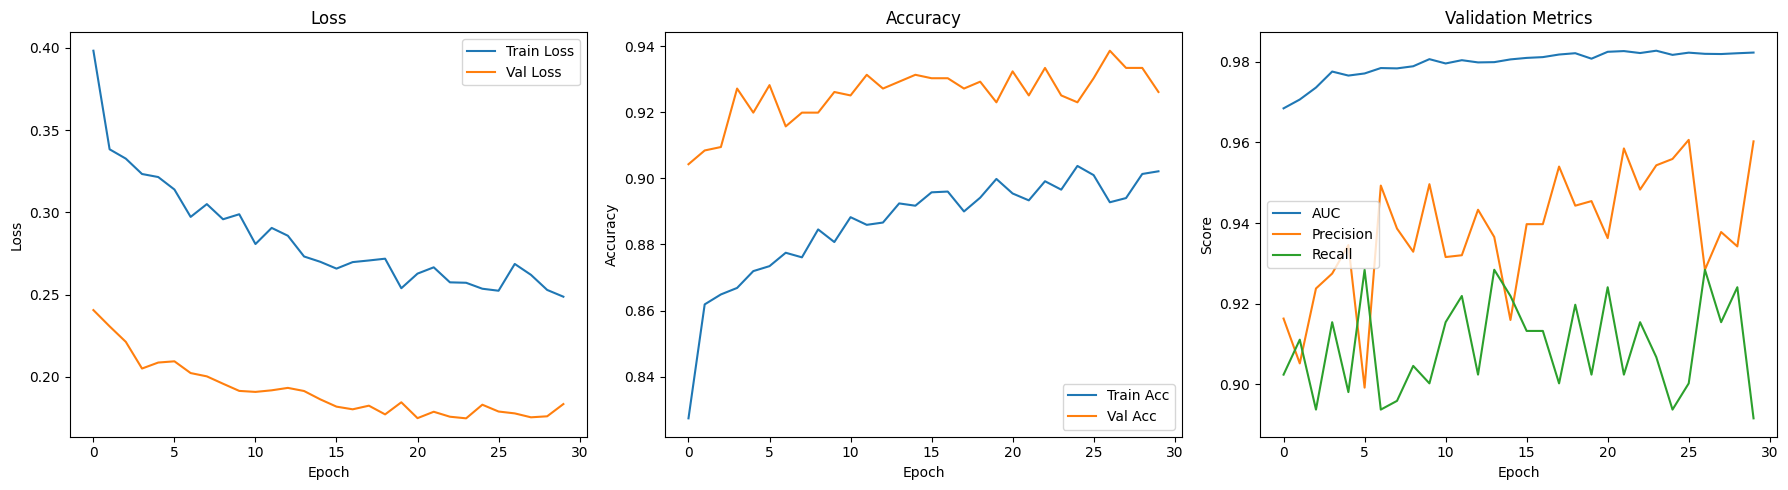

In [15]:
# 11. Train the model
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30)

# Plot training history
plot_history(history)

In [16]:
# 12. Grad-CAM Implementation
from sklearn.metrics import roc_auc_score, precision_score, recall_score

def calculate_metrics(outputs, labels):
    """Calculate AUC, precision, and recall from predictions"""
    # Convert outputs to binary predictions for precision and recall
    predictions = (outputs > 0.5).astype(np.int32)

    # Calculate metrics
    auc = roc_auc_score(labels, outputs)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)

    return auc, precision, recall

In [17]:
class GradCAM:
    def __init__(self, model, layer_name):
        self.model = model
        self.layer_name = layer_name
        self.hooks = []
        self.gradients = None
        self.activations = None

        # Register hooks
        for name, module in self.model.named_modules():
            if name == layer_name:
                self.hooks.append(module.register_forward_hook(self._forward_hook))
                self.hooks.append(module.register_full_backward_hook(self._backward_hook))
                break

    def _forward_hook(self, module, input, output):
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_img, class_idx=None):
        # Forward pass
        self.model.eval()
        self.model.zero_grad()

        # Get model output
        output = self.model(input_img)

        if class_idx is None:
            class_idx = output.argmax(dim=1)

        # Get class score
        # Apply sigmoid to get probability
        probs = torch.sigmoid(output)
        score = probs[:, class_idx] if probs.shape[1] > 1 else probs.squeeze()

        # Backward pass
        score.backward()

        # Pool gradients across the channels
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])

        # Weight activation maps
        activations = self.activations.detach()
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze().cpu()

        # ReLU on top of the heatmap
        heatmap = np.maximum(heatmap.numpy(), 0)

        # Normalize the heatmap
        if np.max(heatmap) > 0:
            heatmap = heatmap / np.max(heatmap)

        # Resize to match input size
        heatmap = cv2.resize(heatmap, (input_img.shape[3], input_img.shape[2]))

        return heatmap

In [18]:
def load_and_preprocess_image(image_path):
    """Load and preprocess a single image for Grad-CAM visualization"""
    transform = val_test_transform
    image = Image.open(image_path).convert('RGB')
    tensor = transform(image).unsqueeze(0).to(device)
    return tensor, image

In [19]:
def display_grad_cam(image, heatmap):
    """Display the original image and the Grad-CAM heatmap"""
    # Convert PIL image to numpy array
    img_np = np.array(image)

    # Create a heatmap
    heatmap_np = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap_np, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Resize heatmap to match the image dimensions
    if img_np.shape[:2] != heatmap_colored.shape[:2]:
        heatmap_colored = cv2.resize(heatmap_colored, (img_np.shape[1], img_np.shape[0]))

    # Superimpose the heatmap on original image
    superimposed = (heatmap_colored * 0.4 + img_np).astype(np.uint8)

    # Display
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img_np)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed)
    plt.title('Melanoma Detection Heatmap')
    plt.axis('off')

    plt.show()

In [20]:
def generate_heatmap(image_path):
    """Generate and display Grad-CAM heatmap for an image"""
    # Load model
    model = SkinCancerModel().to(device)
    model.load_state_dict(torch.load('best_model_b4.pth', map_location=device))
    model.eval()

    # Load image
    img_tensor, original_img = load_and_preprocess_image(image_path)

    # Get the last convolutional layer name
    layer_name = 'efficientnet.features.8'  # This needs to be adjusted based on your model structure

    # Initialize Grad-CAM
    grad_cam = GradCAM(model, layer_name)

    # Generate heatmap
    heatmap = grad_cam(img_tensor)

    # Display results
    display_grad_cam(original_img, heatmap)

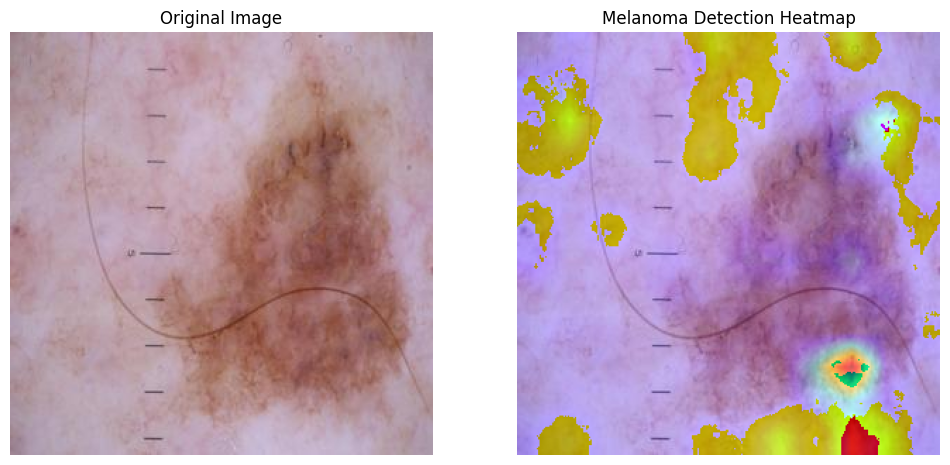

In [23]:
# Example usage
generate_heatmap("./data/test/malignant/melanoma_10105.jpg")

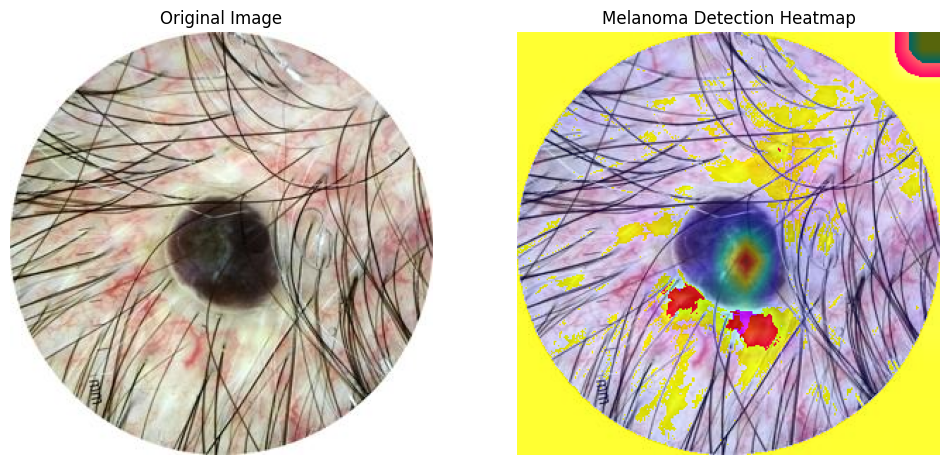

In [24]:
generate_heatmap("./data/test/malignant/melanoma_10110.jpg")

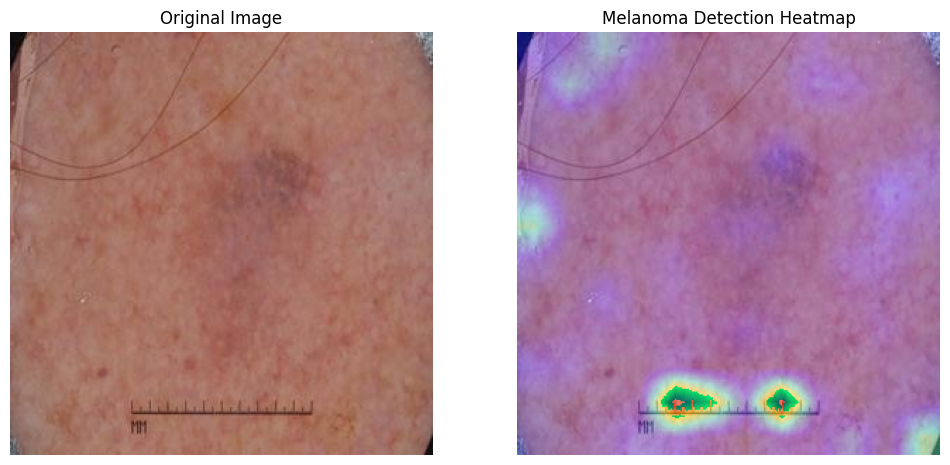

In [26]:
generate_heatmap("./data/test/malignant/melanoma_10132.jpg")